In [ ]:
%load_ext autoreload
%autoreload 2

In [23]:
!pip install scipy==1.2.2
!pip install tflearn
!pip install tensorflow==1.13.2
!pip install keras==2.0.8
!pip install h5py==2.10.0

     ---------------------------------------- 30.0/30.0 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'c:\\users\\borja\\anaconda3\\envs\\tf\\lib\\site-packages\\~cipy\\.libs\\libansari.Y7ANKIMNMVHZXXZWCXL6GFGGYUIM7YOR.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [14]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/balloon"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

import curves

%matplotlib inline 

In [2]:
import os
from datetime import date
from datetime import datetime, timedelta
import pandas as pd, numpy as np
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
days_covered = 120
experiment_date_noTime = date.today()
output_folder = 'logs/'+str(experiment_date_noTime)
os.makedirs(output_folder, exist_ok = True)
print('Output folder: ', output_folder)

Output folder:  logs/2022-10-03


#### Inspect training

In [3]:
config = curves.CurveConfig()
CURVES_DIR = os.path.join(ROOT_DIR, "data/images/")

In [4]:
dataset = curves.CurveDataset()
dataset.load_curve(CURVES_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 6062
Class Count: 2
  0. BG                                                
  1. curve                                             


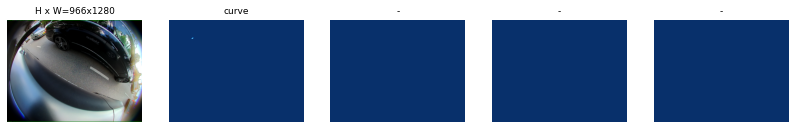

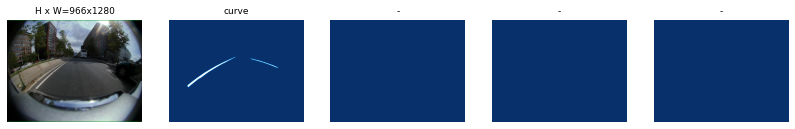

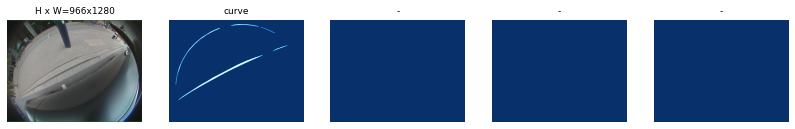

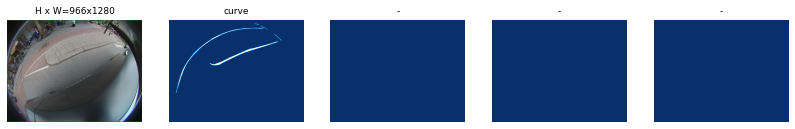

In [5]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  5658 c:\Users\borja\Documents\GitHub\valeo_assessment\data/images/train\images\05658_MVL.png
image                    shape: (966, 1280, 3)        min:    0.00000  max:  255.00000
mask                     shape: (966, 1280, 3)        min:    0.00000  max:  255.00000
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000
bbox                     shape: (3, 4)                min:    0.00000  max: 1170.00000


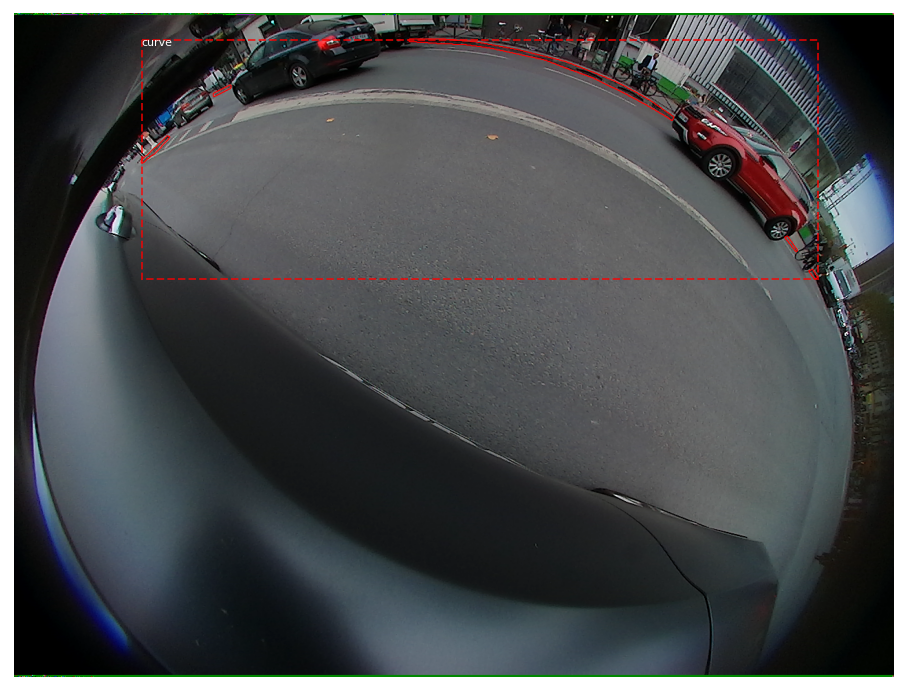

In [6]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

#### Train the model

In [7]:
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           curve
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

In [8]:
config = curves.CurveConfig()
config.display()
model = modellib.MaskRCNN(mode="training", config=config, model_dir= output_folder)


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           curve
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

In [9]:
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

TEST_MODE = "training"

In [10]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [11]:
dataset_train = curves.CurveDataset()
dataset_train.load_curve(CURVES_DIR, "train")

# Must call before using the dataset
dataset_train.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

Images: 6062
Classes: ['BG', 'curve']


In [12]:
dataset_val = curves.CurveDataset()
dataset_val.load_curve(CURVES_DIR, "val")

# Must call before using the dataset
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Images: 938
Classes: ['BG', 'curve']


In [15]:
import tensorflow as tf
with tf.device(DEVICE):
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/2022-10-03\curve20221003T1640\mask_rcnn_curve_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)


ERROR:root:Error processing image {'id': '06612_RV.png', 'source': 'curve', 'path': 'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data/images/val\\images\\06612_RV.png', 'width': 1280, 'height': 966, 'mask_filename': 'c:\\Users\\borja\\Documents\\GitHub\\valeo_assessment\\data/images/val\\masks\\06612_RV.png'}
Traceback (most recent call last):
  File "c:\Users\borja\Documents\GitHub\valeo_assessment\model.py", line 1597, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "c:\Users\borja\Documents\GitHub\valeo_assessment\model.py", line 1166, in load_image_gt
    padding=config.IMAGE_PADDING)
  File "c:\Users\borja\Documents\GitHub\valeo_assessment\utils.py", line 405, in resize_image
    if scale != 1:
  File "c:\Users\borja\Anaconda3\envs\tf\lib\site-packages\skimage\transform\__init__.py", line 4, in <module>
    from .radon_transform import (radon, iradon, iradon_sart,
  File "c:\Users\borja\Anaconda3\envs\tf\lib\site-packages\skimage\transform\radon_transfo

ModuleNotFoundError: No module named 'scipy.fft'

In [14]:
weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  None


TypeError: expected str, bytes or os.PathLike object, not NoneType